## 参数设定

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core import cacul_CRSP
from core import cacul_CFAP
from core import cacul_limit_c, cacul_limit_u, read_limit
from core import chart_preform
from core import svm_weight_score_matrix
%matplotlib inline


## 外参参数
C, gamma = 1,1
K, R = 500, 500

## 分布参数
mean1=[0,0]
mean2=[0,0]
cov1=[[1,0],[0,1]]
cov2=[[1,0],[0,1]]
size1=10
size2=10


## 标准化函数
def Standardization(data):
    import numpy as np
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


## 得分存储

In [5]:
## 存储得分矩阵: 正太分布N(0,E)
import numpy as np
from core import svm_score_matrix

def multinorm_svm_score(ref_size, win_size, I, K=100, R=100, gamma=1, C=1, mean1=[0,0], mean2=[0,0], cov1=[[1,0],[0,1]], cov2=[[1,0],[0,1]]):
    '''存储得分矩阵: 正太分布N(E,0)
    默认IC过程'''
    
    if mean1 == mean2 and cov1 ==cov2:
        name =  "multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}"
    elif mean1 != mean2:
        name =  "OC_multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{mean2[0]-mean1[0]}"

    scores = np.zeros((R, K, I))
    for r in range(R): 
        np.random.seed(r)
        RefDate = np.random.multivariate_normal(mean=mean1,cov=cov1, size=(ref_size*K,))
        MonDate = np.random.multivariate_normal(mean=mean2,cov=cov2, size=(win_size*I,))
        score = svm_score_matrix(RefDate, MonDate, ref_size, win_size, I, K, gamma=1, C=1)
        
        scores[r, :, :] = score
        np.savez(name, scores=scores)


# ##  IC得分矩阵
# I_list = [10, 20]
# ref_size_list = [10, 10, 20, 20, 40, 40]
# win_size_list = [5, 10, 10, 20, 20, 40]
# for I in I_list:
#     for ref_size, win_size in zip(ref_size_list, win_size_list):
#         print(I, ref_size, win_size)
#         multinorm_svm_score(ref_size,win_size, I)


## OC得分矩阵
I = 10
ref_size_list = [20, 20, 40]
win_size_list = [10, 20, 20]

ab_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
for ab in ab_list:
    for ref_size, win_size in zip(ref_size_list, win_size_list):
            print(I, ref_size, win_size)
            multinorm_svm_score(ref_size,win_size, I,  K=100, R=100, gamma=1, C=1, mean1=[0,0], mean2=[ab,0], cov1=[[1,0],[0,1]], cov2=[[1,0],[0,1]])


10 20 10


# IC监控结果

    C:(m,n)=(20,10)  U:(m,n)==(20,10)  C:(m,n)=(20,20)  U:(m,n)==(20,20)  \
0          0.018838          0.273150         0.023742          0.103806   
1          0.002996          0.045059         0.006978          0.070648   
2          0.002996          0.061244         0.005984          0.086441   
3          0.054610          0.457360         0.055560          0.241011   
4          0.007971          0.109228         0.005984          0.046976   
..              ...               ...              ...               ...   
95         0.003993          0.069711         0.007971          0.071584   
96         0.001000          0.006978         0.028624          0.115516   
97         0.001998          0.046018         0.010946          0.070648   
98         0.018838          0.120873         0.030571          0.163547   
99         0.011935          0.061244         0.013912          0.108326   

    C:(m,n)=(40,20)  U:(m,n)==(40,20)  
0          0.024721          0.091040  
1      

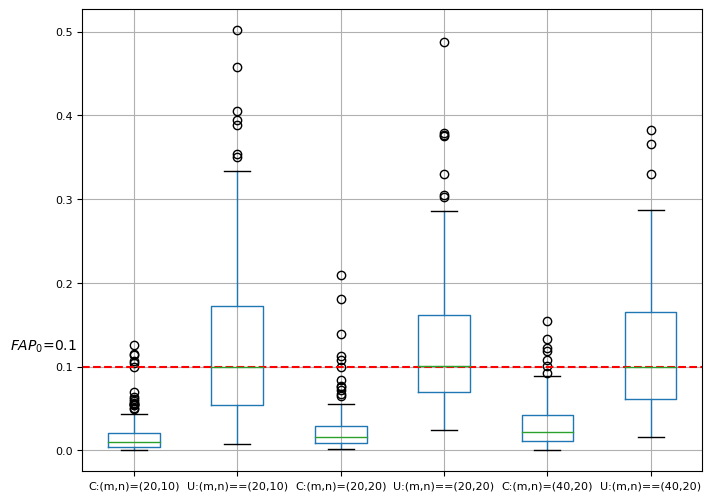

In [ ]:
## 计算CFAP

I_list = [10, 20]
ref_size_list = [10, 10, 20, 20, 40, 40]
win_size_list = [5, 10, 10, 20, 20, 40]

FAP_file_name = "multinorm_"+ 'IC_result.txt' # 存储FAP的分位数,方差和控制线
FAP_data =  pd.DataFrame() # 存储FAP数据
CL_list = []
UL_list = []
for I in I_list:
    for ref_size, win_size in zip(ref_size_list, win_size_list):
        name = f'multinorm_scores_I{I}_ref{ref_size}_win{win_size}'
        data = np.load(name + '.npz')
        IC_scores = data['scores']

        
        #condition 的CFAP
        CL,CFAP = cacul_limit_c(IC_scores, FAP0=0.1, err=0.01)
        CFAP_50, CFAP_75, CFAP_95, CSDFAP = chart_preform(CFAP)
        CL_list.append(CL)

        #uncondition 的CFAP
        UL,UFAP = cacul_limit_u(IC_scores, FAP0=0.1, err=0.01)
        UFAP_50, UFAP_75, UFAP_95, USDFAP = chart_preform(UFAP)
        UL_list.append(UL)

        with open(FAP_file_name, 'a') as f:
            print('conditional', I, ref_size, win_size, CL, '(', CFAP_95, ',', CFAP_75, ',', CFAP_50, ')', CSDFAP, file=f)
            print('unconditional', I, ref_size, win_size, UL, '(', UFAP_95, ',', UFAP_75, ',', UFAP_50, ')', USDFAP, file=f)


        # 存储FAP数据
        if I == 10:
            columns=[f'C:(m,n)=({ref_size},{win_size})',f'U:(m,n)==({ref_size},{win_size})']
            FAP_data[columns[0]] = CFAP
            FAP_data[columns[1]] = UFAP


## 箱线图绘制
box_columns=['C:(m,n)=(20,10)', 'U:(m,n)==(20,10)', 'C:(m,n)=(20,20)', 'U:(m,n)==(20,20)', 'C:(m,n)=(40,20)', 'U:(m,n)==(40,20)']
box_data = FAP_data[box_columns]
print(box_data)

plt.figure(figsize=(8,6))
boxplot=box_data.boxplot(fontsize=8)
plt.axhline(y=0.1, color='r', linestyle='--')
plt.text(-0.2,0.12,'$FAP_0$=0.1')
plt.savefig('coupla_Box_plots_CFAP.eps')
plt.show()
 

## OC监控结果

[0.6330244486851317, 0.691513804292649, 0.5453174630005304]
[0.5911739302126515, 0.6766974495272282, 0.5154271733864102]


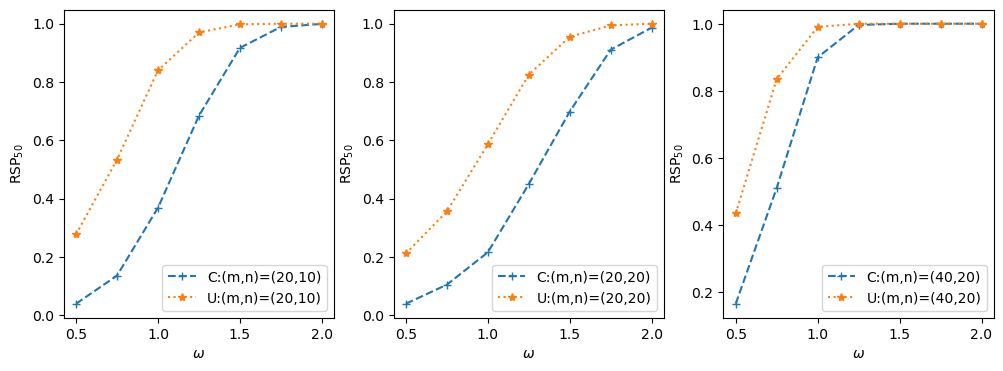

In [ ]:
I = 10
ref_size_list = [20, 20, 40]
win_size_list = [10, 20, 20]
ab_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]

cl_list = CL_list[2:5]
ul_list = UL_list[2:5]
print(cl_list)
print(ul_list)


## 偏移量
ab_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
columns=['C:(m,n)=(20,10)','U:(m,n)=(20,10)','C:(m,n)=(20,20)','U:(m,n)=(20,20)','C:(m,n)=(40,20)','U:(m,n)=(40,20)']


## 计算不同偏移量ab下的RSP
abmean_CRSP50 =pd.DataFrame(np.ones((len(ab_list),len(columns))), index=ab_list, columns=columns)
for i,(ref_size,win_size,cl,ul) in enumerate(zip(ref_size_list,win_size_list,cl_list,ul_list)):
    for ab in ab_list:
        name = "OC_"+ "multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{ab}"
        data = np.load(name + '.npz')
        OC_scores = data['scores']


        CRSP = cacul_CRSP(cl,OC_scores)
        crsp_50 = np.median(CRSP)

        URSP = cacul_CRSP(ul,OC_scores)
        ursp_50 = np.median(URSP)

        abmean_CRSP50.loc[ab,columns[2*i]] = crsp_50
        abmean_CRSP50.loc[ab,columns[2*i+1]] = ursp_50


linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    i = 2*i
    plt.plot(abmean_CRSP50[columns[i]],markers_list[0],linestyle=linestyle_list[0])
    plt.plot(abmean_CRSP50[columns[i+1]],markers_list[1],linestyle=linestyle_list[1])
    plt.legend([columns[i],columns[i+1]])
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)

## ranksum 控制图

In [ ]:
##  正太分布N(0,E)
import numpy as np
# 1. 存储得分矩阵函数
def multinorm_ranksum_score(ref_size, win_size, I, K=1000, R=100, mean1=[0,0], mean2=[0,0], cov1=[[1,0],[0,1]], cov2=[[1,0],[0,1]]):
    '''存储得分矩阵: 正太分布N(E,0)
    默认IC过程'''
    import numpy as np
    from core import ranksum_score_matrix
    if mean1 == mean2 and cov1 ==cov2:
        name =  "rank_scores_" + f"I{I}_ref{ref_size}_win{win_size}"
    elif mean1 != mean2:
        name =  "OC_rank_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{mean2[0]-mean1[0]}"

    scores = np.zeros((R, K, I))
    for r in range(R): 
        np.random.seed(r)
        RefDate = np.random.multivariate_normal(mean=mean1,cov=cov1, size=(ref_size*K,))
        MonDate = np.random.multivariate_normal(mean=mean2,cov=cov2, size=(win_size*I,))
        score = ranksum_score_matrix(RefDate, MonDate, ref_size, win_size, I, K)
        
        scores[r, :, :] = score
        np.savez(name, scores=scores)


## ranksum 1
# ##  IC得分矩阵
I = 10
ref_size_list = [20, 20, 40]
win_size_list = [10, 20, 20]
for ref_size, win_size in zip(ref_size_list, win_size_list):
        print(I, ref_size, win_size)
        multinorm_ranksum_score(ref_size,win_size, I)


# ##  OC得分矩阵
ab_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
for ab in ab_list:
    for ref_size, win_size in zip(ref_size_list, win_size_list):
            print(I, ref_size, win_size)
            multinorm_ranksum_score(ref_size,win_size, I,  K=1000, R=100, mean1=[0,0], mean2=[ab,0], cov1=[[1,0],[0,1]], cov2=[[1,0],[0,1]])


## 2. IC 计算控制限
CL_list_rank = []
UL_list_rank = []
for ref_size, win_size in zip(ref_size_list, win_size_list):
    name = f'rank_scores_I{I}_ref{ref_size}_win{win_size}'
    data = np.load(name + '.npz')
    IC_scores = data['scores']

    
    #condition 的CFAP
    CL,CFAP = cacul_limit_c(IC_scores, FAP0=0.1, err=0.01)
    CFAP_50, CFAP_75, CFAP_95, CSDFAP = chart_preform(CFAP)
    CL_list_rank.append(CL)

    #uncondition 的CFAP
    UL,UFAP = cacul_limit_u(IC_scores, FAP0=0.1, err=0.01)
    UFAP_50, UFAP_75, UFAP_95, USDFAP = chart_preform(UFAP)
    UL_list_rank.append(UL)


## 3. OC 计算不同偏移量ab下的RSP
columns=['C:(m,n)=(20,10)','U:(m,n)=(20,10)','C:(m,n)=(20,20)','U:(m,n)=(20,20)','C:(m,n)=(40,20)','U:(m,n)=(40,20)']
abmean_CRSP50_rank =pd.DataFrame(np.ones((len(ab_list),len(columns))), index=ab_list, columns=columns)
for i,(ref_size,win_size,CL,UL) in enumerate(zip(ref_size_list,win_size_list,CL_list_rank,UL_list_rank)):
    for ab in ab_list:
        name = "OC_"+ "rank_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{ab}"
        data = np.load(name + '.npz')
        OC_scores = data['scores']


        CRSP = cacul_CRSP(CL,OC_scores)
        crsp_50 = np.median(CRSP)

        URSP = cacul_CRSP(UL,OC_scores)
        ursp_50 = np.median(URSP)

        abmean_CRSP50_rank.loc[ab,columns[2*i]] = crsp_50
        abmean_CRSP50_rank.loc[ab,columns[2*i+1]] = ursp_50


linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    i = 2*i
    plt.plot(abmean_CRSP50_rank[columns[i]],markers_list[0],linestyle=linestyle_list[0])
    plt.plot(abmean_CRSP50[columns[i]],markers_list[1],linestyle=linestyle_list[1])
    plt.legend([columns[i], columns[i]],loc='lower right')
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)

plt.show()

ranksum_2

In [6]:
import numpy as np

class Params:
    def __init__(self, dist_type, K=100, R=100, ab=0, **kwargs):
        self.dist_type = dist_type
        self.K = K
        self.R = R
        self.ab = ab  # Adjust to 0 by default for the 'In-Control' scenario
        self.params = kwargs

    def get(self, key, default=None):
        return self.params.get(key, default)

    def get_data_generator(self):
        '''根据分布类型返回相应的数据生成器和相关参数'''
        if self.dist_type == 'multinorm':
            mean1 = self.get('mean1', [0, 0])
            mean2 = self.get('mean2', [self.ab, 0])
            cov1 = self.get('cov1', [[1, 0], [0, 1]])
            cov2 = self.get('cov2', [[1, 0], [0, 1]])
            data_generator = np.random.multivariate_normal
            return data_generator, {'mean': mean1, 'cov': cov1}, {'mean': mean2, 'cov': cov2}

        elif self.dist_type == 'correlated_multinorm':
            mean1 = self.get('mean1', [0, 0])
            mean2 = self.get('mean2', [self.ab, 0])
            cov1 = self.get('cov1', [[1, 1], [1, 1]])
            cov2 = self.get('cov2', [[1, 1], [1, 1]])
            data_generator = np.random.multivariate_normal
            return data_generator, {'mean': mean1, 'cov': cov1}, {'mean': mean2, 'cov': cov2}

        elif self.dist_type == 'gamma':
            a = self.get('a', 1)
            b = self.get('b', 1)
            ab = self.get('ab', self.ab)
            data_generator = lambda size, a=a, b=b, ab=ab: np.random.gamma(shape=a, scale=b, size=(size, 2)) + ab
            return data_generator, {'a': a, 'b': b, 'ab': 0}, {'a': a, 'b': b, 'ab': ab} # prama1和param2分别为ref和mon参数

        else:
            raise ValueError("Unsupported distribution type.")

def generate_scores(ref_size, win_size, I, params):
    '''根据指定的分布类型生成分数矩阵并存储'''
    from core import ranksum_2_score_matrix

    # 获取数据生成器和参数
    data_generator, param1, param2 = params.get_data_generator()

    # name前缀
    name_prefix = "IC" if params.ab == 0 else "OC"
    name_suffix = f"I{I}_ref{ref_size}_win{win_size}_ab{params.ab}"
    name = f"{name_prefix}_rank_2_{params.dist_type}_scores_{name_suffix}"

    # 生成数据和分数
    scores = np.zeros((params.R, params.K, I))
    for r in range(params.R):
        RefData = data_generator(size=ref_size * params.K, **param1)
        MonData = data_generator(size=win_size * I, **param2)
        score = ranksum_2_score_matrix(RefData, MonData, ref_size, win_size, I, params.K)
        scores[r, :, :] = score

    # 存储得分矩阵
    np.savez(name, scores=scores)

if __name__ == '__main__':
    multinorm_params = Params('gamma', K=10, R=10, ab=0)
    generate_scores(ref_size= 10, win_size=20, I=10, params=multinorm_params)


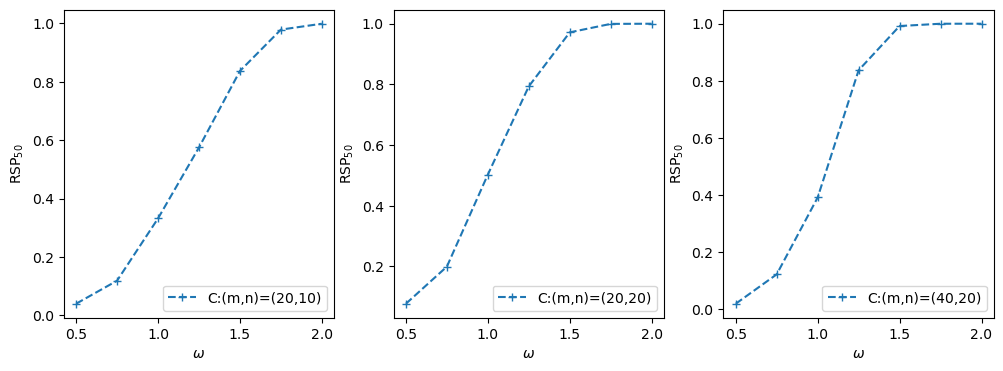

In [11]:
# ## ranksum 2
# # ##  IC得分矩阵
I = 10
ref_size_list = [20, 20, 40]
win_size_list = [10, 20, 20]
# ## 运行得分计算
# for ref_size, win_size in zip(ref_size_list, win_size_list):
#         print("IC",I, ref_size, win_size)
#         # # 正太分布N(0,I)
#         multinorm_params = Params('multinorm', K=100, R=100, ab=0)
#         generate_scores(ref_size, win_size, I, params=multinorm_params)
#         # 相关分布N(0, E)
#         multinorm_params = Params('correlated_multinorm', K=100, R=100, ab=0)
#         generate_scores(ref_size, win_size, I, params=multinorm_params)
#         # Gamma 分布 G(a,b)
#         multinorm_params = Params('gamma', K=100, R=100, ab=0)
#         generate_scores(ref_size, win_size, I, params=multinorm_params)



# # # ##  OC得分矩阵
# ab_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
# for ab in ab_list:
#     for ref_size, win_size in zip(ref_size_list, win_size_list):
#             print("OC",I, ref_size, win_size)
#             # # 正太分布N(0,I)
#             multinorm_params = Params('multinorm', K=100, R=100, ab=ab)
#             generate_scores(ref_size, win_size, I, params=multinorm_params)
#             # 相关分布N(0, E)
#             multinorm_params = Params('correlated_multinorm', K=100, R=100, ab=ab)
#             generate_scores(ref_size, win_size, I, params=multinorm_params)
#             # Gamma 分布 G(a,b)
#             multinorm_params = Params('gamma', K=100, R=100, ab=ab)
#             generate_scores(ref_size, win_size, I, params=multinorm_params)




## 2. IC 计算控制限
CL_list_rank = []
UL_list_rank = []
for ref_size, win_size in zip(ref_size_list, win_size_list):
    name = f'IC_rank_2_correlated_multinorm_scores_I{I}_ref{ref_size}_win{win_size}_ab{0}'
    data = np.load(name + '.npz')
    IC_scores = data['scores']

    
    #condition 的CFAP
    CL,CFAP = cacul_limit_c(IC_scores, FAP0=0.1, err=0.01)
    CFAP_50, CFAP_75, CFAP_95, CSDFAP = chart_preform(CFAP)
    CL_list_rank.append(CL)

    #uncondition 的CFAP
    UL,UFAP = cacul_limit_u(IC_scores, FAP0=0.1, err=0.01)
    UFAP_50, UFAP_75, UFAP_95, USDFAP = chart_preform(UFAP)
    UL_list_rank.append(UL)




## 3. OC 计算不同偏移量ab下的RSP
columns=['C:(m,n)=(20,10)','U:(m,n)=(20,10)','C:(m,n)=(20,20)','U:(m,n)=(20,20)','C:(m,n)=(40,20)','U:(m,n)=(40,20)']
abmean_CRSP50_rank_2 =pd.DataFrame(np.ones((len(ab_list),len(columns))), index=ab_list, columns=columns)
for i,(ref_size,win_size,CL,UL) in enumerate(zip(ref_size_list,win_size_list,CL_list_rank,UL_list_rank)):
    for ab in ab_list:
        name = "OC_"+ "rank_2_correlated_multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}_ab{ab}"
        data = np.load(name + '.npz')
        OC_scores = data['scores']


        CRSP = cacul_CRSP(CL,OC_scores)
        crsp_50 = np.median(CRSP)

        URSP = cacul_CRSP(UL,OC_scores)
        ursp_50 = np.median(URSP)

        abmean_CRSP50_rank_2.loc[ab,columns[2*i]] = crsp_50
        abmean_CRSP50_rank_2.loc[ab,columns[2*i+1]] = ursp_50


linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    i = 2*i
    plt.plot(abmean_CRSP50_rank_2[columns[i]],markers_list[0],linestyle=linestyle_list[0])
    # plt.plot(abmean_CRSP50[columns[i]],markers_list[1],linestyle=linestyle_list[1])
    plt.legend([columns[i], columns[i]],loc='lower right')
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)
plt.show()

# 对columns_MWR_II重命名,并保存abmean_CRSP50_rank
columns_MWR_II= ['MWR_II:(m,n)=(20,10)', 'MWR_II_U:(m,n)=(20,10)', 'MWR_II:(m,n)=(20,20)', 'MWR_II_U:(m,n)=(20,20)', 'MWR_II:(m,n)=(40,20)', 'MWR_II_U:(m,n)=(40,20)']
abmean_CRSP50_rank_2.columns=columns_MWR_II
abmean_CRSP50_rank_2.to_csv('abmean_CRSP50_rank_II_correlated_multinorm.csv')

   Unnamed: 0  NMFHP:(m,n)=(20,10)  NMFHP_U:(m,n)=(20,10)  \
0        0.25              0.08022               0.277640   
1        0.50              0.14891               0.533921   
2        0.75              0.30083               0.840100   
3        1.00              0.59409               0.969882   
4        1.25              0.88974               0.997968   
5        1.50              0.98961               0.999950   
6        1.75              1.00000               1.000000   
7        2.00              1.00000               1.000000   

   NMFHP:(m,n)=(20,20)  NMFHP_U:(m,n)=(20,20)  NMFHP:(m,n)=(40,20)  \
0             0.088260               0.092876              0.09331   
1             0.140890               0.211635              0.25779   
2             0.272340               0.355654              0.66366   
3             0.508994               0.586392              0.96461   
4             0.791940               0.825088              0.99642   
5             0.963690        

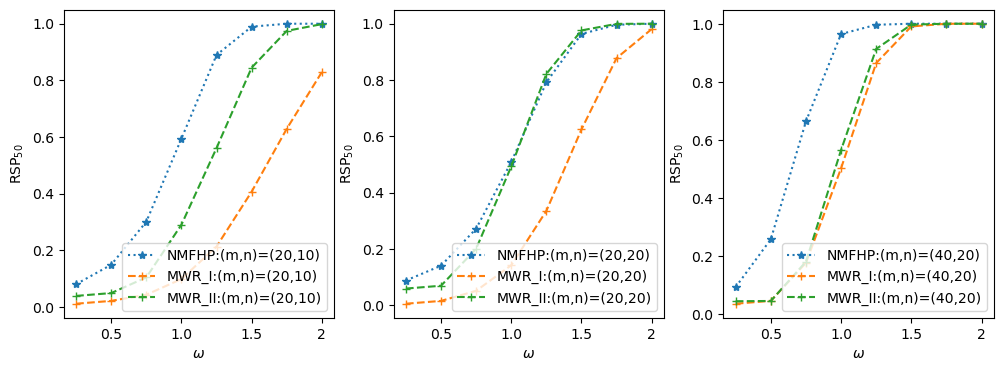

In [58]:
## 画图
abmean_CRSP50 = pd.read_csv('abmean_CRSP50.csv')
abmean_CRSP50_rank_I = pd.read_csv('abmean_CRSP50_rank_I.csv')
abmean_CRSP50_rank_II = pd.read_csv('abmean_CRSP50_rank_II.csv')

ab_list = [0.5, 1.0, 1.5,  2]

print(abmean_CRSP50)
linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    column_index = 2 * i +1
    print(column_index)
    plt.plot(abmean_CRSP50.iloc[:, column_index],markers_list[1],linestyle=linestyle_list[1])
    plt.plot(abmean_CRSP50_rank_I.iloc[:, column_index],markers_list[0],linestyle=linestyle_list[0])
    plt.plot(abmean_CRSP50_rank_II.iloc[:, column_index],markers_list[0],linestyle=linestyle_list[0])
    plt.legend([abmean_CRSP50.columns[column_index],abmean_CRSP50_rank_I.columns[column_index],abmean_CRSP50_rank_II.columns[column_index]],loc='lower right')
    #x轴的刻度 
    plt.xticks([1,3,5,7],ab_list)
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)
    #保存为高清pdf文件
    plt.savefig('figure7.pdf',dpi=300,bbox_inches='tight')
plt.show()




In [ ]:
# 存档
# 1. 存储得分矩阵函数 
import numpy as np

def multinorm_ranksum_2_score(ref_size, win_size, I, K=100, R=100, mean1=[0,0], mean2=[0,0], cov1=[[1,0],[0,1]], cov2=[[1,0],[0,1]]):
    '''正太分布N(0,I)'''
    from core import ranksum_2_score_matrix
    if mean1 == mean2 and cov1 ==cov2:
        name =  "rank_2_scores_" + f"I{I}_ref{ref_size}_win{win_size}"
    elif mean1 != mean2:
        name =  "OC_rank_2_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{mean2[0]-mean1[0]}"

    scores = np.zeros((R, K, I))
    for r in range(R): 
        RefDate = np.random.multivariate_normal(mean=mean1,cov=cov1, size=(ref_size*K,))
        MonDate = np.random.multivariate_normal(mean=mean2,cov=cov2, size=(win_size*I,))
        score = ranksum_2_score_matrix(RefDate, MonDate, ref_size, win_size, I, K)
        
        scores[r, :, :] = score
        np.savez(name, scores=scores)


def multinorm_ranksum_2_score_correlated(ref_size, win_size, I, K=100, R=100, mean1=[0,0], mean2=[0,0], cov1=[[1,1],[1,1]], cov2=[[1,1],[1,1]]):
    ''' 相关分布N(0, E) '''
    from core import ranksum_2_score_matrix
    if mean1 == mean2 and cov1 ==cov2:
        name = "rank_2_correlated_multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}"
    elif mean1 != mean2:
        name = "OC_rank_2_correlated_multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{mean2[0]-mean1[0]}"

    scores = np.zeros((R, K, I))  
    for r in range(R):
        RefData = np.random.multivariate_normal(mean=mean1, cov=cov1, size=(ref_size*K,))
        MonData = np.random.multivariate_normal(mean=mean2, cov=cov2, size=(win_size*I,))
        score = ranksum_2_score_matrix(RefData, MonData, ref_size, win_size, I, K)
        scores[r, :, :] = score
        np.savez(name, scores=scores)

def gamma_ranksum_2_score(ref_size, win_size, I, K=100, R=100, a=1, b=1, abmean=0):
    '''Gamma 分布 G(a,b)'''
    from core import ranksum_2_score_matrix
    if abmean==0:
        name = "rank_2_gamma_scores_" + f"I{I}_ref{ref_size}_win{win_size}"
    elif abmean !=0:
        name = "OC_rank_2_gamma_scores_" + f"I{I}_ref{ref_size}_win{win_size}_abmean{abmean}"
    
    scores = np.zeros((R, K, I))
    for r in range(R):
        RefData = np.random.gamma(shape=a, scale=b, size=(ref_size*K, 2))
        MonData = np.random.gamma(shape=a, scale=b, size=(win_size*I, 2))
        score = ranksum_2_score_matrix(RefData, MonData, ref_size, win_size, I, K)
        scores[r, :, :] = score
        np.savez(name, scores=scores)
